<a href="https://colab.research.google.com/github/sreeja-g/wind_speed_forecasting/blob/master/wind_speed_hour_parallelized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os

In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [0]:
try:
  spark.stop()
except:
  pass
  
from pyspark import SparkContext
sc = SparkContext(appName="wind_forecast")
from pyspark.sql import SparkSession
spark=SparkSession(sc)

In [6]:
!pip install ewtpy

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ewtpy
import glob

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
import gzip
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
all_files = glob.glob("drive/My Drive/wind_data_large/*.txt")

li = []

for filename in all_files:
    print(filename)
    df = pd.read_csv(filename, sep = ', ', header = None, engine='python')
    li.append(df)

drive/My Drive/wind_data_large/midas_wind_202001-202012.txt
drive/My Drive/wind_data_large/midas_wind_201901-201912.txt
drive/My Drive/wind_data_large/midas_wind_201701-201712.txt
drive/My Drive/wind_data_large/midas_wind_201801-201812.txt
drive/My Drive/wind_data_large/midas_wind_201601-201612.txt
drive/My Drive/wind_data_large/midas_wind_201501-201512.txt
drive/My Drive/wind_data_large/midas_wind_201401-201412.txt
drive/My Drive/wind_data_large/midas_wind_201301-201312.txt
drive/My Drive/wind_data_large/midas_wind_201201-201212.txt


In [0]:
data = pd.concat(li, axis=0, ignore_index=True)

In [0]:
speed_data=pd.DataFrame(data[9].values,columns=['speed'])

In [0]:
speed_data.index=pd.to_datetime(data[0], format='%Y-%m-%d %H:%M')
speed_data.index.name = 'date_time'

In [13]:
speed_data

,speed
date_time,
2020-01-01 00:00:00,5.0
2020-01-01 00:00:00,6.0
2020-01-01 00:00:00,17.0
2020-01-01 00:00:00,26.0
2020-01-01 00:00:00,20.0
...,...
2012-12-31 23:00:00,10.0
2012-12-31 23:00:00,10.0
2012-12-31 23:00:00,NaN


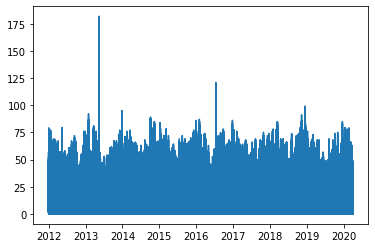

In [14]:
plt.plot(speed_data)

In [15]:
speed_data.head()

,speed
date_time,
2020-01-01,5.0
2020-01-01,6.0
2020-01-01,17.0
2020-01-01,26.0
2020-01-01,20.0


In [16]:
speed_data.isna().sum()

speed    245649
dtype: int64

In [17]:
speed_data=speed_data.fillna(speed_data.bfill())
speed_data.isna().sum()

speed    3
dtype: int64

In [18]:
speed_data.head()

,speed
date_time,
2020-01-01,5.0
2020-01-01,6.0
2020-01-01,17.0
2020-01-01,26.0
2020-01-01,20.0


In [19]:
speed_data=speed_data.resample('H').mean()
speed_data.sort_index()

,speed
date_time,
2012-01-01 00:00:00,14.612360
2012-01-01 01:00:00,14.840336
2012-01-01 02:00:00,15.302521
2012-01-01 03:00:00,15.022284
2012-01-01 04:00:00,15.011236
...,...
2020-03-31 19:00:00,7.890173
2020-03-31 20:00:00,6.942197
2020-03-31 21:00:00,6.534483


In [20]:
speed_data.head()

,speed
date_time,
2012-01-01 00:00:00,14.612360
2012-01-01 01:00:00,14.840336
2012-01-01 02:00:00,15.302521
2012-01-01 03:00:00,15.022284
2012-01-01 04:00:00,15.011236


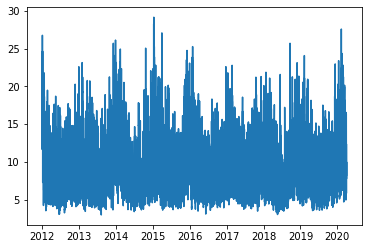

In [21]:
plt.plot(speed_data)

In [0]:
speed_data_grouped = [grp['speed'].values.tolist() for key, grp in speed_data.groupby([speed_data.index.hour])]

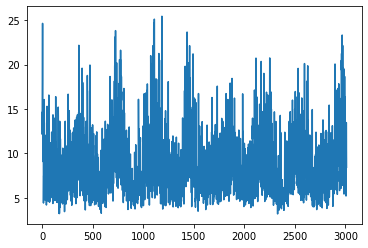

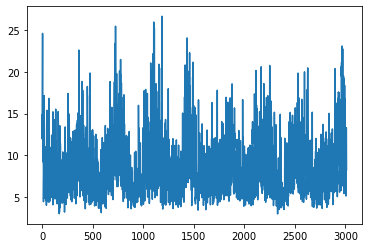

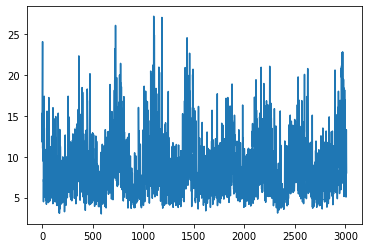

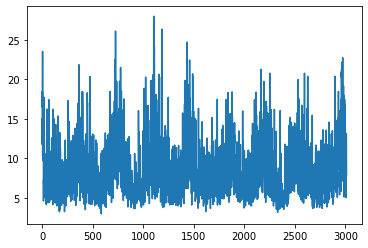

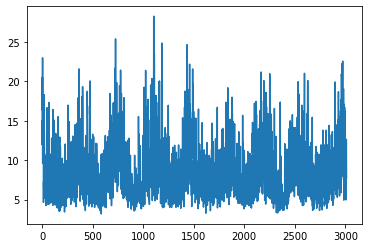

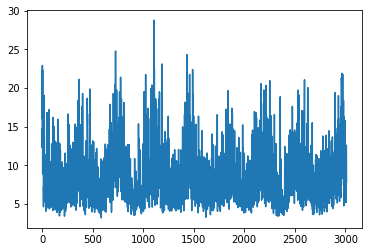

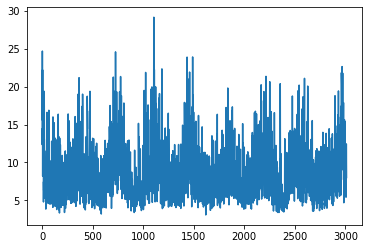

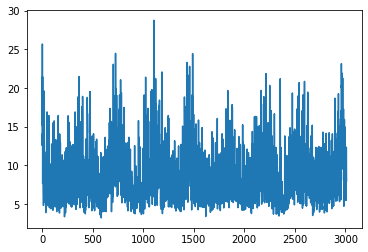

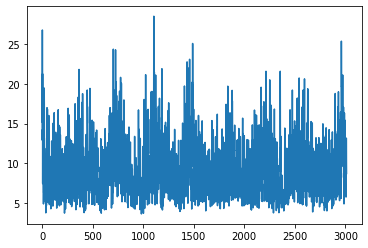

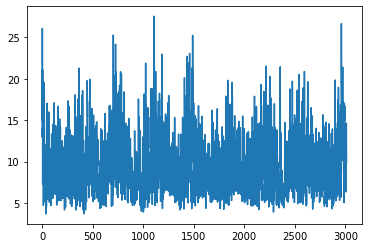

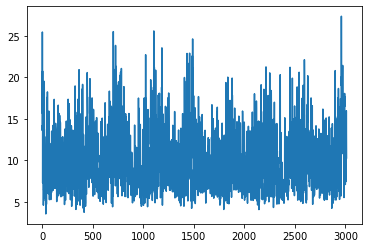

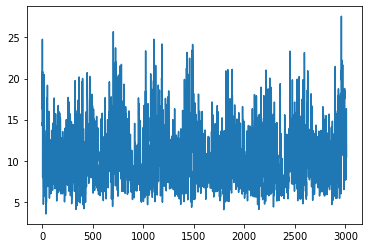

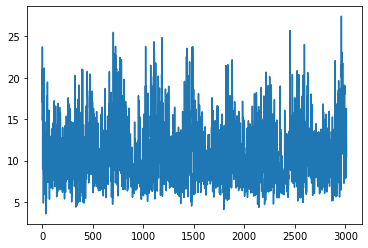

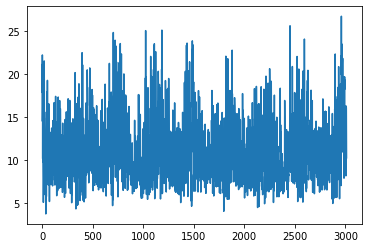

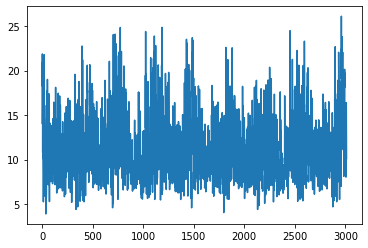

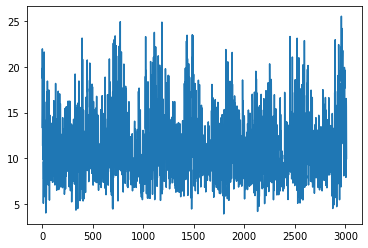

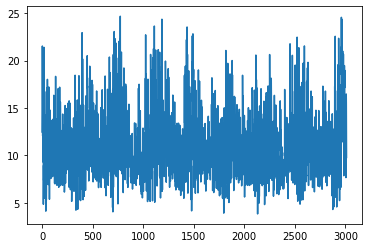

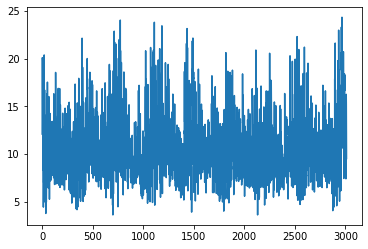

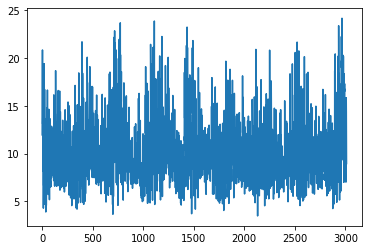

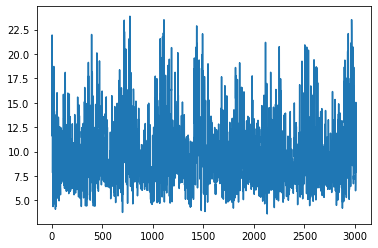

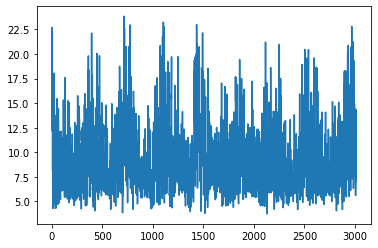

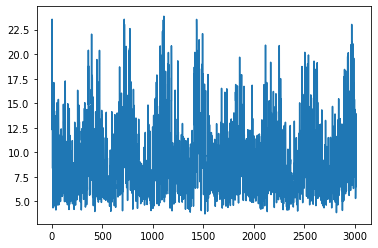

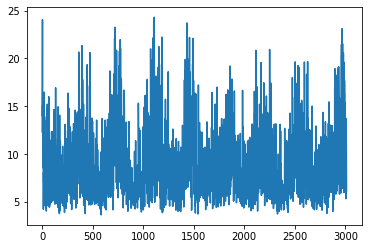

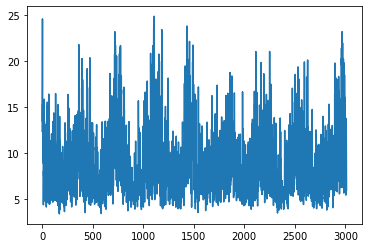

In [23]:
for each in speed_data_grouped:
  plt.plot(each)
  plt.show()

###Elm

In [0]:


class Elm:

  def __init__(self,w_0=None,b_0=None,beta=None):
    self.n_value =55
    self.m_value = 1
    self.l_value = int((2/3)*(self.n_value+self.m_value))

    if w_0 is not None:
      self.weights = np.array(w_0)
      self.bias = np.array(b_0)
      self.beta = np.array(beta)
    else:
      self.weights = 2*np.random.random((self.n_value,self.l_value)) - 1
      self.bias = 2*np.random.random((self.l_value)) - 1
      self.beta = beta
    
    

  def fit(self,X_train,y_train):

    H=self.get_H_matrix(X_train)
    self.beta=np.matmul(np.linalg.pinv(H),y_train)
    return (self.weights,self.bias,self.beta)

  def predict(self,X_test):
    H=self.get_H_matrix(X_test)
    return np.matmul(H,self.beta)


  def get_H_matrix(self,x):
    H = np.empty((0,self.l_value))
    for i in range(len(x)):
      f_x,g_x=0,0
      f_x=np.matmul(x[i],self.weights)+self.bias 
      g_x=self.sigmoid(f_x) 
      H=np.append(H,[g_x],axis=0)
    return H


  def sigmoid(self,value):
    return 1/(1 + np.exp(-value))


  


In [0]:
def make_lag_data(x_data,n_value,m_value):
  X = []
  y = []
  for i in range(n_value, len(x_data)-m_value+1):
    X.append(x_data[(i-n_value):(i)])
    y.append(x_data[i:i+m_value])
  X=np.array(X)
  X=X.reshape(X.shape[0],X.shape[1])
  y=np.array(y)
  y=y.reshape(y.shape[0],y.shape[1])
  return (X,y)

In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
ewtpy_value=20

X_train_all=[[] for i in range(ewtpy_value)]
y_train_all=[[] for i in range(ewtpy_value)]
X_test_all=[[] for i in range(ewtpy_value)]
y_test_all=[[] for i in range(ewtpy_value)]

for each in speed_data_grouped:

  ewt,  mfb ,boundaries = ewtpy.EWT1D(np.array(each), N = ewtpy_value)
  ewt=ewt.transpose()

  data_all=[]
  for i in range(len(ewt)):
    wavelet=ewt[i]
    wavelet=np.array(wavelet)
    wavelet=np.reshape(wavelet, (-1, 1))
    data_all.append(wavelet)

  for i in range(len(data_all)):
    
    wavelet=data_all[i]

    input_values=55
    output_values=1

    (X,y)=make_lag_data(wavelet,input_values,output_values)


    X_train = X[:int(len(X)*0.78)]
    y_train = y[:int(len(y)*0.78)]

    X_test = X[int(len(X)*0.78):]
    y_test = y[int(len(y)*0.78):]

    X_train_all[i].append(X_train)
    y_train_all[i].append(y_train)
    X_test_all[i].append(X_test)
    y_test_all[i].append(y_test)
    


In [0]:
def train_model(X_train_,y_train_):
  elm_=Elm()
  return elm_.fit(X_train_,y_train_)

In [0]:
learnt_elms=[]
for i in range(ewtpy_value):

  learning_step=sc.parallelize(X_train_all[i]).zipWithIndex().map(lambda x: train_model(X_train_all[i][x[1]],y_train_all[i][x[1]])).collect()

  learnt_elms.append(learning_step)


In [0]:
y_test_collected=[[] for i in range(len(X_test_all[0]))]
y_pred_collected=[[] for i in range(len(X_test_all[0]))]

for i in range(ewtpy_value): 

  for j in range(len(X_test_all[i])):

    y_test_collected[j].append(y_test_all[i][j])
    new_elm=Elm(learnt_elms[i][j][0],learnt_elms[i][j][1],learnt_elms[i][j][2])
    y_pred_collected[j].append(new_elm.predict(X_test_all[i][j]))


test data
mse:  6.853288469150835
mae:  2.0012608432977363
mape:  24.643782886482775


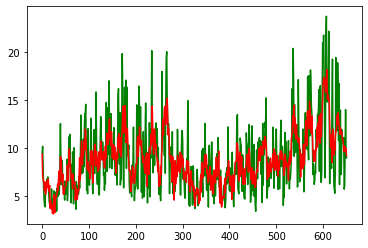

test data
mse:  6.812511267166686
mae:  2.0246026560255626
mape:  25.594697218269413


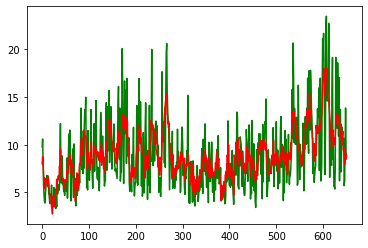

test data
mse:  6.457149049040612
mae:  1.9606838619569569
mape:  24.45612657100497


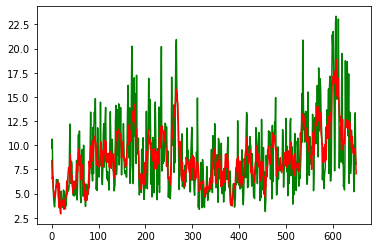

test data
mse:  6.269346100585796
mae:  1.9108923454292868
mape:  23.756009323079752


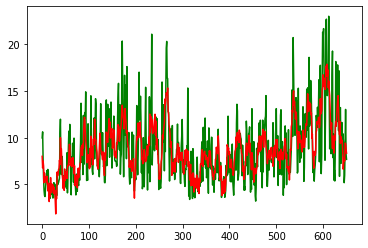

test data
mse:  6.356338304897201
mae:  1.9061618712763622
mape:  23.5465543506276


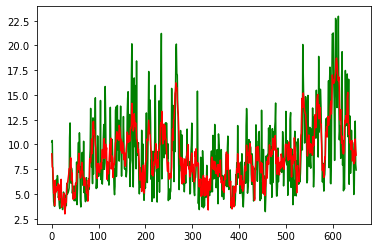

test data
mse:  6.050624867583214
mae:  1.8498890352896122
mape:  22.828222362995838


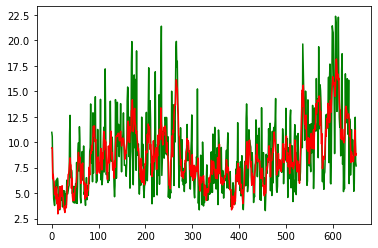

test data
mse:  6.696517422756195
mae:  2.0161069679001264
mape:  24.86134931662021


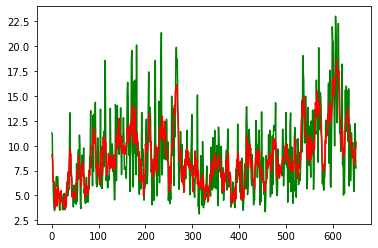

test data
mse:  6.5279320924156465
mae:  1.982753803853845
mape:  24.2087438620157


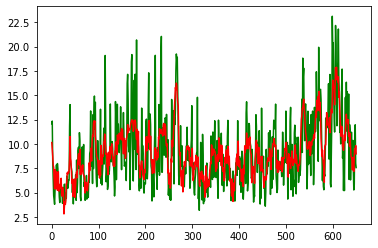

test data
mse:  6.462890313727942
mae:  1.9741972509680359
mape:  22.998251230112963


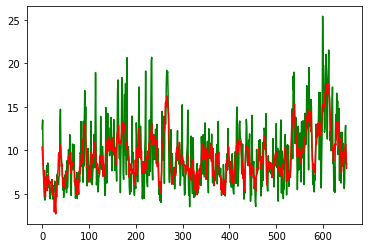

test data
mse:  6.6969182512646555
mae:  1.9874431428694286
mape:  22.19027928156204


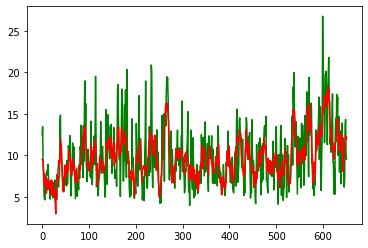

test data
mse:  7.031632480039311
mae:  2.049128892827435
mape:  21.7536935358591


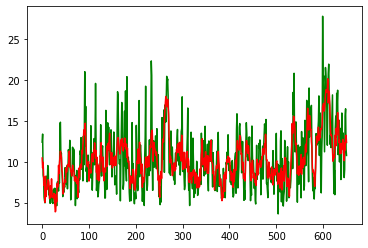

test data
mse:  6.3185108018246465
mae:  1.922241825810435
mape:  19.416387050059956


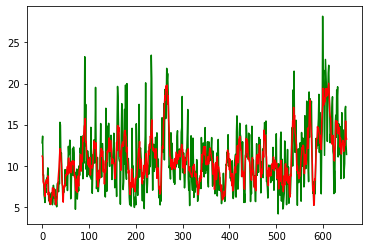

test data
mse:  7.075024173592268
mae:  2.04300611688167
mape:  19.9265146607579


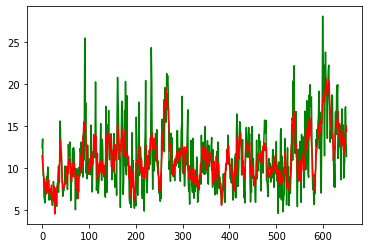

test data
mse:  6.717508740777644
mae:  2.000195682999622
mape:  19.10379991907053


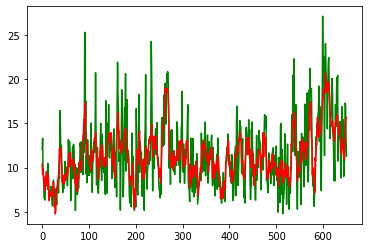

test data
mse:  6.364061689922312
mae:  1.9404933805730826
mape:  18.36163159331519


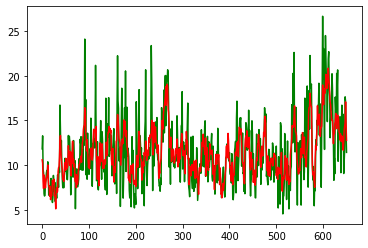

test data
mse:  6.5743432555631145
mae:  1.9448683265682254
mape:  18.45789983554084


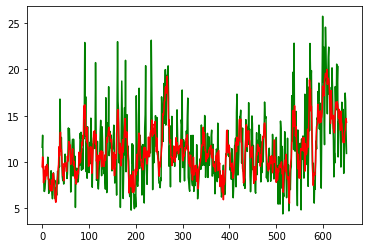

test data
mse:  6.5899334205916835
mae:  1.958805070759055
mape:  19.069079895139208


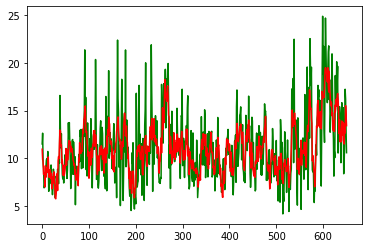

test data
mse:  6.668834592420924
mae:  1.9466898989485233
mape:  19.569690050821524


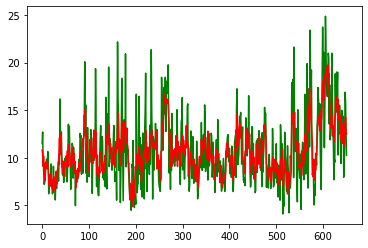

test data
mse:  7.300915843121729
mae:  2.0601523317247765
mape:  21.480676077805132


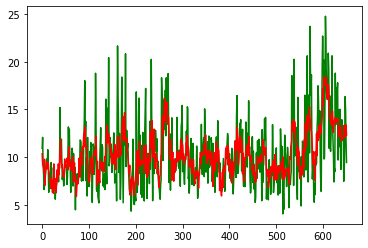

test data
mse:  7.111947611567249
mae:  2.025204756528863
mape:  22.36953128427498


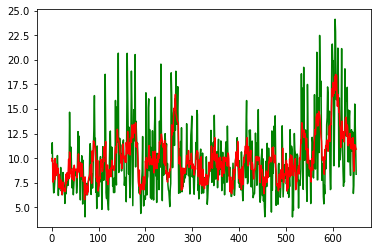

test data
mse:  6.643512856932501
mae:  1.9234629935384429
mape:  21.706358444415425


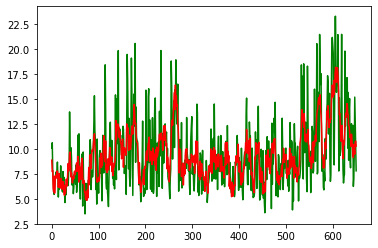

test data
mse:  6.602649352676767
mae:  1.9345386769432955
mape:  22.550611045896293


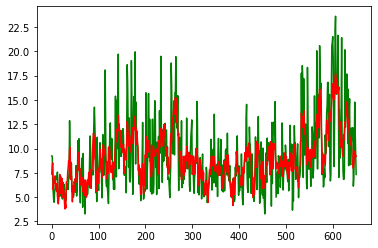

test data
mse:  7.037743466268976
mae:  2.014190267336959
mape:  24.33585880315534


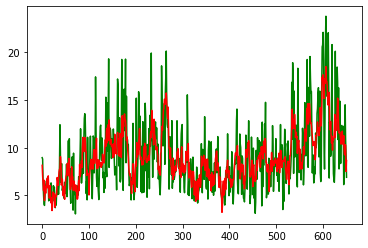

test data
mse:  6.751435661656464
mae:  1.9876576178588765
mape:  24.157937270788743


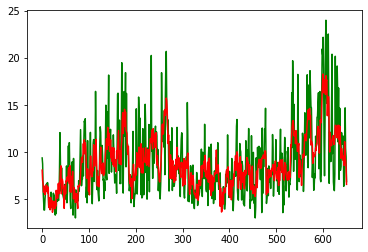

In [33]:
for i in range(len(y_test_collected)):

  y_test_all=np.sum(y_test_collected[i],axis=0)
  y_pred_all=np.sum(y_pred_collected[i],axis=0)

  print("test data")
  print("mse: ",mean_squared_error(y_test_all,y_pred_all))
  print("mae: ",mean_absolute_error(y_test_all,y_pred_all))
  print("mape: ",mean_absolute_percentage_error(y_test_all,y_pred_all))

  plt.plot(y_test_all,color='green')
  plt.plot(y_pred_all,color='red')
  plt.show()